In [31]:
import numpy as np
from scipy.special import logsumexp
import re
import matplotlib.pyplot as plt
%matplotlib inline

def trans_to_nuc_abunds(trans_abunds_vec, trans_lengths_vec):
    """Given a vector of transcription abundances and a vector of transcript lengths, returns the nucelotide 
    abundances as a list"""
    
    if len(trans_abunds_vec) != len(trans_lengths_vec): return False
    
    num_transcripts = len(trans_abunds_vec)
    nuc_abunds_list = np.multiply(trans_abunds_vec, trans_lengths_vec)
    nuc_abunds_tot = sum(nuc_abunds_list)
    nuc_abunds_list = np.true_divide(nuc_abunds_list, nuc_abunds_tot)
    
    return nuc_abunds_list

def nuc_to_trans_abunds(nuc_abunds_vec, trans_lengths_vec):
    """Given a vector of nucleotide abundances and a vector of transcript lengths, returns the transcript
    abundances as a list"""
    
    if len(nuc_abunds_vec) != len(trans_lengths_vec): return False
    
    num_transcripts = len(nuc_abunds_vec)
    trans_abunds_list = np.true_divide(nuc_abunds_vec, trans_lengths_vec)
    trans_abunds_tot = sum(trans_abunds_list)
    trans_abunds_list = np.true_divide(trans_abunds_list, trans_abunds_tot)
    
    return trans_abunds_list

def generate_rand_abunds_and_lens(trans_num, len_range):
    """Generates a (nearly) uniform random vector of transcript abundances using the dirichlet distribution, and 
    random lengths sampled from the range given by a tuple len_range. Both the transcript abundances and the lengths
    vectors will have a number of elements equal to trans_num"""

    abunds_list = list(np.random.dirichlet(np.ones(trans_num),size=1)[0])
    lens_list = list(np.random.randint(len_range[0], len_range[1]+1, trans_num))
    
    return abunds_list, lens_list

def create_arc(trans_lens_vec):
    """"""
    trans_list = []
    
    num_segs = len(trans_lens_vec)
    seg_list = [i for i in range(num_segs)]
    
    for start_seg, trans_len in enumerate(trans_lens_vec):
        end_seg = start_seg+trans_len
        if end_seg > num_segs:
            transcript = seg_list[start_seg:]+seg_list[:end_seg-num_segs]
            trans_list.append(list(transcript))
            
        else: trans_list.append(seg_list[start_seg:end_seg])
    
    return trans_list

def create_reads(trans_vec, trans_abunds_vec, trans_lens_vec, N):
    """"""
    trans_num = len(trans_vec)
    nuc_abunds_list = trans_to_nuc_abunds(trans_abunds_vec, trans_lens_vec)
    reads_list = []
    for i in range(N):
        transcript_idx = np.random.choice(trans_num,p=nuc_abunds_list)
        transcript = trans_vec[transcript_idx]
        segment = np.random.choice(transcript)
        reads_list.append(segment)
        
    return reads_list

In [2]:
trans_abunds_list, trans_lens_list = generate_rand_abunds_and_lens(10, (2,4))
transcript_list = create_arc(trans_lens_list)
reads_list = create_reads(transcript_list, trans_abunds_list, trans_lens_list, 1000000)

In [3]:
def calc_nll(reads_vec, trans_vec, trans_abunds_vec, trans_lens_vec):
    """"""
    nuc_abunds_list = trans_to_nuc_abunds(trans_abunds_vec, trans_lens_vec)
    log_probs_list = []
    unique_reads_arr, unique_read_counts_arr = np.unique(reads_vec, return_counts=True)
    
    # Iterate over each read
    for read_idx, read in enumerate(unique_reads_arr):
        read_prob_list = []
        
        # For each read, iterate over each transcript
        for trans_idx, transcript in enumerate(trans_vec):
            
            # If the transcript contains the read sequence, calculate the probability that the read came from this
            # transcript and add it to the probability list for this transcript (this implicitly sums ove both S and
            # T), but the if statement means we only get non-zero probabilities
            if read in transcript:
                prob = np.log(nuc_abunds_list[trans_idx]/trans_lens_vec[trans_idx])
                read_prob_list.append(prob)
        
        # Add the total log probability for this unique read
        total_read_log_prob = logsumexp(read_prob_list)*unique_read_counts_arr[read_idx]
        log_probs_list.append(total_read_log_prob)
        
    total_nll = -1*np.sum(log_probs_list)
    
    return total_nll

def get_lestrade_ests(reads_vec, trans_vec, trans_lens_vec):
    """"""
    trans_num = len(trans_lens_vec)
    trans_counts_list = [0]*trans_num
    
    # Iterate over each read
    for read in reads_vec:
        temp_counts = [0]*trans_num
        
        # For each read, add a count for each transcript that include the segment that generated the read
        for idx, transcript in enumerate(trans_vec):
            if read in transcript:
                temp_counts[idx] += 1
                
        # Normalize the counts to add to 1
        temp_tot = sum(temp_counts)
        temp_counts = np.true_divide(temp_counts, temp_tot)
        
        # Add the count proportions for each read to the total counts list
        trans_counts_list = np.add(trans_counts_list, temp_counts)
    
    counts_tot = sum(trans_counts_list)
    est_nuc_abunds_list = np.true_divide(trans_counts_list, counts_tot)
    est_trans_abunds_list = nuc_to_trans_abunds(est_nuc_abunds_list, trans_lens_vec)
    
    return est_trans_abunds_list
        

In [4]:
lestrade_trans_abunds_list = get_lestrade_ests(reads_list, transcript_list, trans_lens_list)
true_nll = calc_nll(reads_list, transcript_list, trans_abunds_list, trans_lens_list)
lestrade_nll = calc_nll(reads_list, transcript_list, lestrade_trans_abunds_list, trans_lens_list)

In [5]:
print("True transcript abundances:")
print(trans_abunds_list)
print("\nLestrade's transcript abundances:")
print(lestrade_trans_abunds_list)
print("\nDifference:")
print(np.abs(np.subtract(trans_abunds_list, lestrade_trans_abunds_list)))

print("\n\nNegative log-likelyhood of true parameters:")
print(true_nll)
print("\nNegative log-likelyhood of Lestrade's parameters:")
print(lestrade_nll)
print("\nNLL difference: ")
print(np.abs(true_nll-lestrade_nll))

True transcript abundances:
[0.22111032211698162, 0.09452841111016967, 0.03693414919724495, 0.004239418402130973, 0.2044030150700933, 0.07872984959963751, 0.0687190372690769, 0.07338643208072933, 0.1506872108424614, 0.06726215431147456]

Lestrade's transcript abundances:
[0.14725604 0.08594707 0.05867936 0.08810391 0.10166208 0.09469925
 0.08577359 0.09542388 0.12574808 0.11670675]

Difference:
[0.07385428 0.00858134 0.02174521 0.08386449 0.10274094 0.0159694
 0.01705455 0.02203745 0.02493913 0.04944459]


Negative log-likelyhood of true parameters:
2232013.1061513373

Negative log-likelyhood of Lestrade's parameters:
2247166.91324849

NLL difference: 
15153.807097152807


In [20]:
def read_data_from_file(file_name):
    """TAKEN FROM LESTRADE AND ADAPTED FOR OUR PURPOSES. Reads a data table of the format output by Lestrade and 
    returns the read counts and transcript lengths"""
    with open(file_name) as f:
        #   The first line is "The <n> transcripts of the sand mouse Arc locus"
        line  = f.readline()
        match = re.search(r'^The (\d+) transcripts', line)
        T     = int(match.group(1))

        # The next T lines are 
        #   <Arcn>  <true_tau> <L> <structure>
        # tau's may be present, or obscured ("xxxxx")
        tau       = np.zeros(T)
        L         = np.zeros(T).astype(int)
        tau_known = True   # until we see otherwise
        for i in range(T):
            fields    = f.readline().split()
            if fields[1] == "xxxxx":
                tau_known = False
            else:
                tau[i] = float(fields[1])
            L[i]      = int(fields[2])

        # after a blank line,
        # 'The <n> read sequences':
        line  = f.readline()
        line  = f.readline()
        match = re.search(r'The (\d+) read sequences', line)
        N     = int(match.group(1))

        # the next T lines are 
        #  <read a-j> <count>
        r = np.zeros(T).astype(int)
        for k in range(T):
            fields = f.readline().split()
            r[k]   = fields[1]
            
    read_counts_list = list(r)
    
    return(read_counts_list, L)

def run_EM_optimization(reads_vec, trans_vec, trans_lens_vec, N):
    """"""
    #TODO add a NLL tracker that checks every 100 iterations whether or not it has converged. Plan is to have a
    # max number of iterations that can be shortcut when the NLL is static
    initial_trans_abunds = generate_rand_abunds_and_lens(len(trans_lens_vec), (1,1))[0]
        
    nuc_abunds_list = nuc_to_trans_abunds(initial_trans_abunds, trans_lens_vec)
    trans_num = len(trans_lens_vec)
    unique_reads_arr, unique_read_counts_arr = np.unique(reads_vec, return_counts=True)
    nll_list = [-1]
    
    for iteration in range(N):
        count_arr = np.zeros(10)

        # Iterate over each read
        for read_idx, read in enumerate(unique_reads_arr):
            read_prob_list = []
            idx_list = []
            # For each read, iterate over each transcript
            for trans_idx, transcript in enumerate(trans_vec):
                # If the read is present in the transcript, add its log probability numerator to read_prob_list
                if read in transcript:
                    idx_list.append(trans_idx)
                    numer = np.log(nuc_abunds_list[trans_idx]/trans_lens_vec[trans_idx])
                    read_prob_list.append(numer)

            # Normalize the probabilities by subtracting the log probability of the denominator from each element 
            # of read_prob_list
            denom = logsumexp(read_prob_list)
            read_prob_list = np.subtract(read_prob_list, denom)

            # Add the exponentiated probabilities to the cooresponding transcript count in count_arr
            total_read_counts = np.multiply(np.exp(read_prob_list),unique_read_counts_arr[read_idx])
            np.add.at(count_arr, idx_list, total_read_counts)
            
        # Get nucleotide abunces from counts, then record the corresponding transcript abundances
        new_nuc_abunds = np.divide(count_arr, np.sum(count_arr))
        nuc_abunds_list = new_nuc_abunds
        final_trans_abunds_list = nuc_to_trans_abunds(nuc_abunds_list, trans_lens_vec)

        # Keep track of the NLL every 100 iterations. If the NLL has not changed more that 0.01 in the last 100
        # iterations, stop iterating and report the current transcript abundance estimates
        if iteration%100 == 0:
                nll = calc_nll(reads_vec, trans_vec, final_trans_abunds_list, trans_lens_vec)

                if nll_list[0] == -1:
                    nll_list[0] = nll

                elif np.abs(np.subtract(nll_list[-1], nll)) < 0.01:
                    nll_list.append(nll)
                    print("Number of Iterations: " + str(iteration))
                    return final_trans_abunds_list, nll_list

                else: nll_list.append(nll)

    print("Number of Iterations: " + str(N))
    
    return final_trans_abunds_list, nll_list

            
            

In [ ]:
# Gather the parameters needed for EM optimization
read_counts_list, trans_lens_list = read_data_from_file("w08-data.out")
reads_list = []

for read_idx, read_count in enumerate(read_counts_list):
    reads_list += [read_idx]*read_count
    
arc_transcript_list = create_arc(trans_lens_list)

# Run the EM optimization
my_est_abunds_arr, nll_list = run_EM_optimization(reads_list, arc_transcript_list, trans_lens_list, 5000)

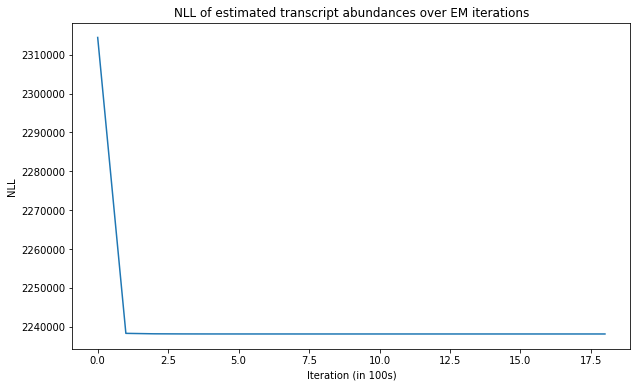

In [34]:
# Plot the NLL over the iterations
plt.figure(figsize=(10,6))
plt.plot(nll_list)
plt.xlabel("Iteration (in 100s)")
plt.ylabel("NLL")
plt.title("NLL of estimated transcript abundances over EM iterations")
plt.show()

In [19]:
lestrade_est_abunds_list = get_lestrade_ests(reads_list, arc_transcript_list, trans_lens_list)
my_nll = calc_nll(reads_list, arc_transcript_list, my_est_abunds_arr, trans_lens_list)
lestrade_nll = calc_nll(reads_list, arc_transcript_list, lestrade_est_abunds_list, trans_lens_list)
print("My estimated transcript abundances:")
print(list(my_est_abunds_arr))
print("\nLestrade's estimated transcript abundances:")
print(lestrade_est_abunds_list)
print("\nDifference:")
print(np.abs(np.subtract(my_est_abunds_arr, lestrade_est_abunds_list)))

print("\n\nNegative log-likelyhood of my parameters:")
print(my_nll)
print("\nNegative log-likelyhood of Lestrade's parameters:")
print(lestrade_nll)
print("\nNLL difference: ")
print(np.abs(my_nll-lestrade_nll))

My estimated transcript abundances:
[0.052550273287946356, 0.09783696837448036, 0.0629846882770073, 0.11651023084586129, 0.04397473219150514, 0.302408321221761, 0.002309430627240861, 0.07361951336788286, 0.061161533668779064, 0.18664430813753585]

Lestrade's estimated transcript abundances:
[0.0896395  0.09112976 0.07383159 0.10491783 0.11192892 0.12457224
 0.11018329 0.08591525 0.09649783 0.11138378]

Difference:
[0.03708923 0.00670721 0.0108469  0.0115924  0.06795419 0.17783609
 0.10787386 0.01229574 0.0353363  0.07526053]


Negative log-likelyhood of my parameters:
2238099.539598462

Negative log-likelyhood of Lestrade's parameters:
2253910.9353717305

NLL difference: 
15811.395773268305


In [10]:
# test_trans_abunds_list, test_trans_lens_list = generate_rand_abunds_and_lens(10, (2,4))
# test_transcript_list = create_arc(test_trans_lens_list)
# test_reads_list = create_reads(test_transcript_list, test_trans_abunds_list,
#                                                 test_trans_lens_list, 10000)

# test_run = iterate_EM(test_reads_list, test_transcript_list,
#                             test_trans_lens_list, 1000)

# print(test_trans_abunds_list)
# print(test_run)
# print(np.abs(np.subtract(test_trans_abunds_list, test_run)))

In [11]:
read_counts_list, len_list = read_data_from_file("w08-data.out")
arc_transcript_list = create_arc(len_list)
print(arc_transcript_list)

[[0, 1, 2, 3], [1, 2], [2, 3, 4], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7], [6, 7], [7, 8], [8, 9, 0], [9, 0, 1]]


In [12]:
100%15

10